# Previous analysis

- Disease feature defined at dataset level but a dataset contains multiple diseases and healthy samples

- Dataset integration is not recommended: different datasets use different numerical ranges to express miRNA values

    - Bias: the model maps the dataset range to its disease

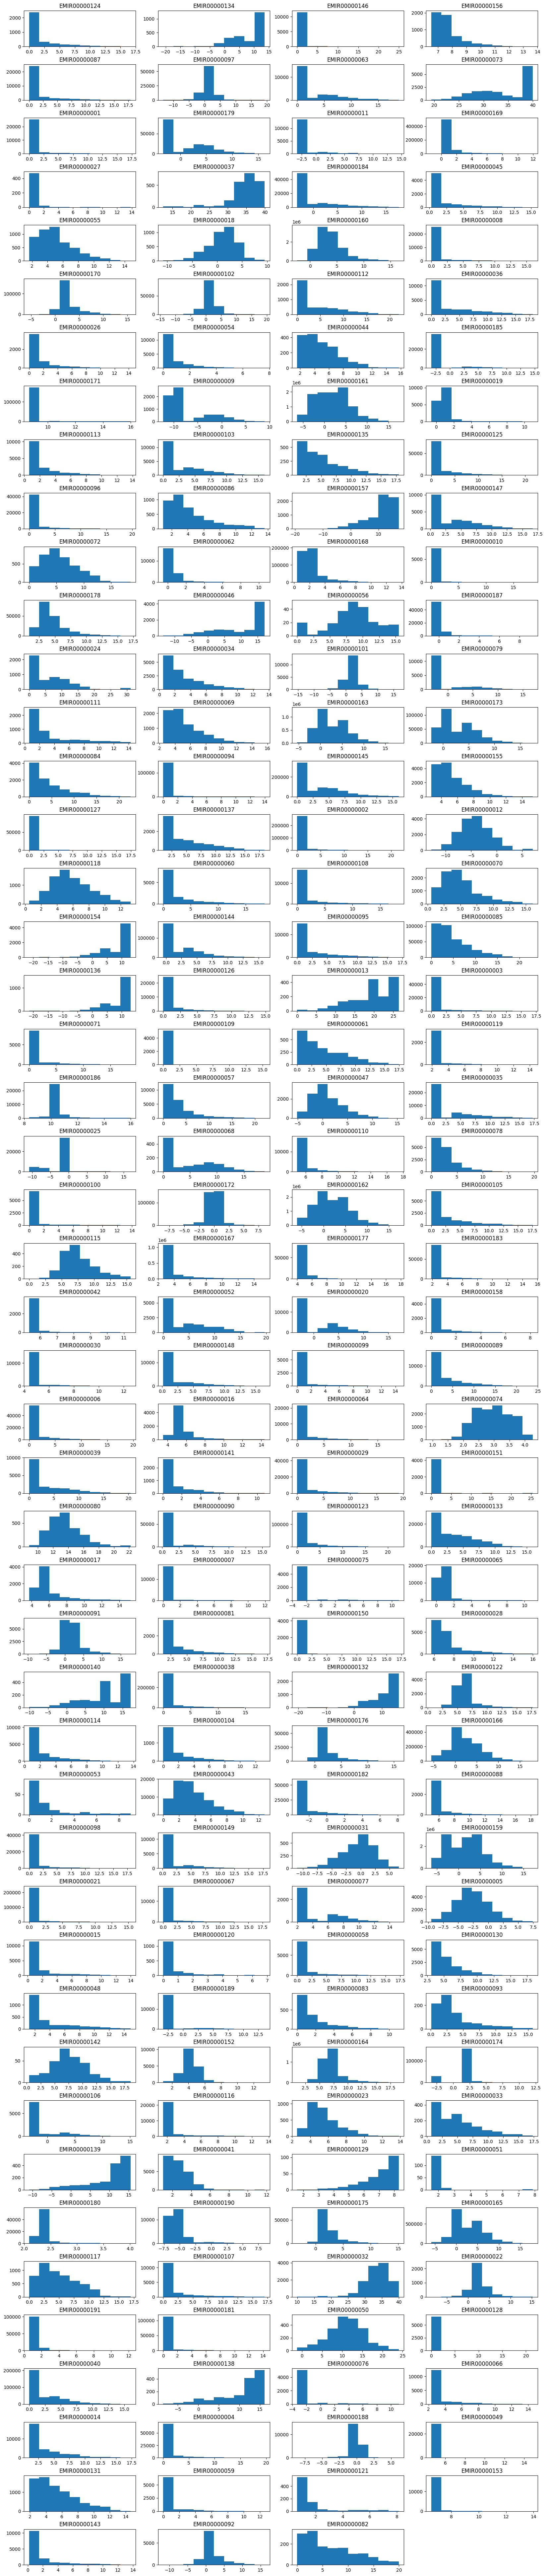

In [7]:
import glob
import pandas as pd
import matplotlib.pyplot as plt


fig, axs = plt.subplots(48, 4, figsize=(20, 100), gridspec_kw={'hspace': 0.5})
for i, filename in enumerate(glob.glob('data/raw/exp/*.csv')):
    values = pd.read_csv(filename, index_col=0).values.flatten()
    axs[i//4, i%4].hist(values)
    axs[i//4, i%4].set_title(filename.split('/')[-1][:-8])
    
axs[-1, -1].set_visible(False)

plt.show()

# Dataset Selection

- Datasets: 191

- Samples: 29.198

### OpenRefine:
A powerful free, open source tool for working with messy data: cleaning it, transforming it from one format into another and extending it with web services and external data.

- Retrieve platform *technology* from [Gene Expression Omnibus](https://0-www-ncbi-nlm-nih-gov.brum.beds.ac.uk/geo/browse/?view=platforms)

  |Technology                 |Datasets|Samples |
  |---------------------------|-------:|-------:|
  |high-throughput sequencing |64      |1473    |
  |spotted oligonucleotide    |35      |24119   |
  |in situ oligonucleotide    |61      |2987    |
  |RT-PCR                     |28      |544     |
  |other                      |3       |75      |
<br/>

- |Deleted Datasets           |Notes                                                                                      |
  |---------------------------|:------------------------------------------------------------------------------------------|
  |technology = RT-PCR        |[Not microarray](https://biosistemika.com/blog/qpcr-microarrays-rna-sequencing-choose-one) |
  |technology = other         |Unknown                                                                                    |
  |EMIR00000180               |[Inconsistency with EMIR00000177](./Report.numbers)                                        |
  |EMIR00000091               |Subsets of EMIR00000102                                                                    |
  |EMIR00000092               |Subsets of EMIR00000102                                                                    |
  |EMIR00000097               |Subsets of EMIR00000102                                                                    |
  |EMIR00000101               |Subsets of EMIR00000102                                                                    |
  |EMIR00000010               |Not related to diseases                                                                    |
  |EMIR00000011               |Not related to diseases                                                                    |
  |EMIR00000023               |Not related to diseases                                                                    |
  |EMIR00000026               |Not related to diseases                                                                    |
  |EMIR00000028               |Not related to diseases                                                                    |
  |EMIR00000038               |Not related to diseases                                                                    |
  |EMIR00000081               |Not related to diseases                                                                    |
  |EMIR00000095               |Not related to diseases                                                                    |
  |EMIR00000096               |Not related to diseases                                                                    |
  |EMIR00000123               |Not related to diseases                                                                    |
  |EMIR00000133               |Not related to diseases                                                                    |
  |EMIR00000137               |Not related to diseases                                                                    |
  |EMIR00000158               |Not related to diseases                                                                    |

# Metadata Preprocessing

### OpenRefine

- Concatenate metadata files in a single table

- Add dataset-level features

- Split and transpose **key:value** features

- |Delete Samples                         |Number  |
  |---------------------------------------|-------:|
  |Organism ≠ homo sapiens                |22      |
  |Channel count = 2                      |189     |
  |Molecule ≠ total RNA                   |2       |
  |Disease status not clear (EMIR00000090)|13      |
  |Disease status not clear (EMIR00000008)|4       |
  |Disease status not clear (EMIR00000067)|3       |
  |Disease status not clear (EMIR00000102)|30      |
  |Disease status not clear (EMIR00000166)|9       |
  |Disease status not clear (EMIR00000168)|9       |

In [11]:
import pandas as pd


def keep_first_occurrence(row):
    new_row = []
    for value in row:
        new_row.append(value if value not in new_row else None)
    return pd.Series(new_row, index=row.index)

# Delete repeated occurrences of the same value in the same row
metadata = pd.read_csv('data/PD.csv', dtype=str).apply(keep_first_occurrence, axis=1)

# Remove columns containing the same value in all rows
metadata.drop(metadata.columns[metadata.apply(pd.Series.nunique) == 1], axis=1, inplace=True)

# Remove empty columns
metadata.dropna(axis=1, how='all', inplace=True)

metadata.to_csv('data/PD.csv', index=False)

### OpenRefine

- Merge equivalent features associated to different datasets

- Rename features consistently

- Delete irrelevant or redundant features (e.g. *state* has an almost 1:1 relationship with *city*)

- Delete features where missing values ⪆ 98%

- Refine dataset-level features (based on majority class) using sample-level data
        
- Detect healthy samples in each dataset

- Standardize *age*, *sex*, *city*, *disease*, *disease_type* features

- Meaning of *metastasis* and *stage* is dataset-specific (not standardizable)

In [1]:
import pandas as pd


metadata = pd.read_csv('data/PD.csv')

# Delete datasets containing less than 10 healthy samples
counts = metadata.groupby('dataset').disease.apply(lambda x: x.isna().sum())
valid_datasets = counts[counts > 10].index
metadata = metadata[metadata.dataset.isin(valid_datasets)]

metadata.to_csv('data/PD.csv', index=False)
metadata.head()

,sample_id,dataset,dataset_technology,dataset_country,dataset_city,dataset_sample_type,sex,age,stage,metastasis,disease,disease_type,disease_body_site
0,GSM1081746,EMIR00000168,in situ oligonucleotide,USA,Research Triangle Park,Serum circulating miRNA,NaN,63.0,NaN,NaN,Breast cancer,Cancer,Breast
1,GSM1081747,EMIR00000168,in situ oligonucleotide,USA,Research Triangle Park,Serum circulating miRNA,NaN,46.0,NaN,NaN,NaN,NaN,NaN
2,GSM1081748,EMIR00000168,in situ oligonucleotide,USA,Research Triangle Park,Serum circulating miRNA,NaN,44.0,NaN,NaN,Breast cancer,Cancer,Breast
3,GSM1081749,EMIR00000168,in situ oligonucleotide,USA,Research Triangle Park,Serum circulating miRNA,NaN,65.0,NaN,NaN,NaN,NaN,NaN
4,GSM1081750,EMIR00000168,in situ oligonucleotide,USA,Research Triangle Park,Serum circulating miRNA,NaN,59.0,NaN,NaN,NaN,NaN,NaN


Total samples: 25484


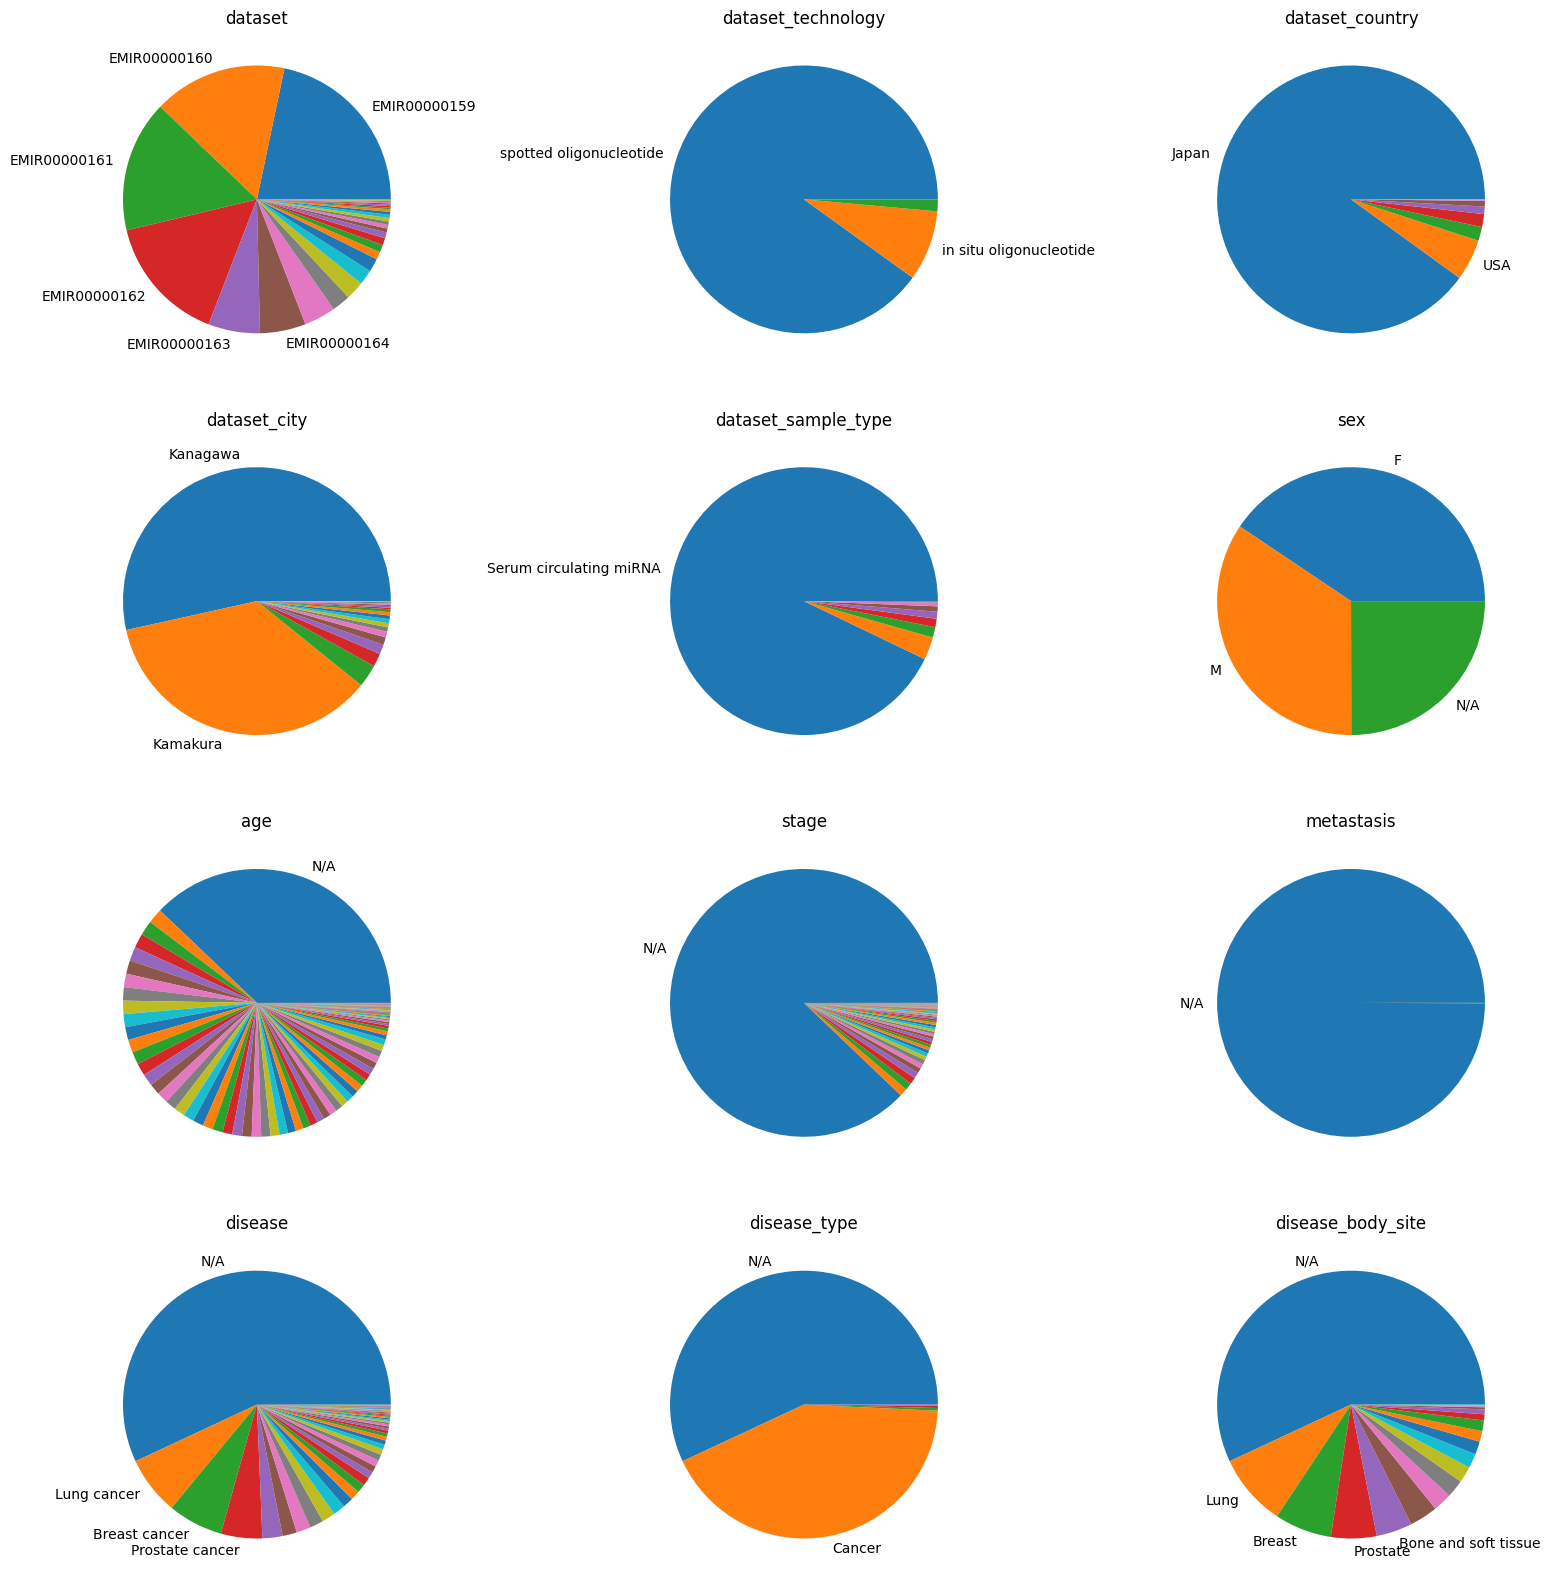

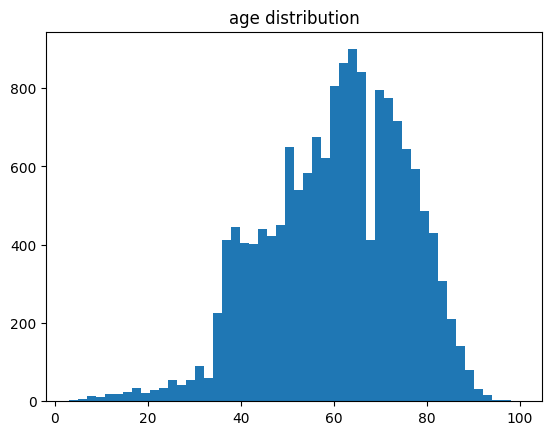

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


metadata = pd.read_csv('data/PD.csv', index_col=0)
print(f'\033[1mTotal samples: {len(metadata)}\033[0m')

# Visualize feature distribution
fig, axs = plt.subplots(4, 3, figsize=(20, 20))
for i, column in enumerate(metadata.columns):
    counts = metadata[column].value_counts(dropna=False)
    labels = [label if count > 1000 else '' for count, label in zip(counts, counts.index)]
    labels = ['N/A' if pd.isnull(label) else label for label in labels]
    axs[i//3, i%3].set_title(f'{column}')
    axs[i//3, i%3].pie(counts, labels=labels)

plt.show()
plt.hist(metadata.age, bins=50)
plt.title('age distribution')
plt.show()

# miRNA Preprocessing

### [miRBaseConverter](https://taoshengxu.shinyapps.io/mirbaseconverter/)

- Convert miRNA names to the latest version of miRBase (v.22)

- Retrieve miRNA sequence 

In [3]:
import pandas as pd


mirna = pd.read_csv('data/raw/miRNA.tsv', sep='\t')
name_converter = dict(zip(mirna.OriginalName, mirna.miRNAName_v22))

def convert_miRNA_name(name):
    name = name.strip()
    name = name.split('_v1')[0]
    name = name.split('_v2')[0]
    return name_converter[name]

datasets = pd.read_csv('data/PD.csv').groupby('dataset').sample_id.agg(list).to_dict()

values = []
for dataset, samples in datasets.items():

    # Strip, remove version suffix and update miRNA names
    df = pd.read_csv(f'data/raw/exp/{dataset}_exp.csv', converters={0: convert_miRNA_name})

    # Delete rows indexed by unknown miRNA names
    df.dropna(subset=df.columns[0], inplace=True)

    # Delete rows indexed by repeated miRNA names (dataset anomaly)
    df.drop_duplicates(df.columns[0], inplace=True)

    # Transpose data
    df = df.set_index(df.columns[0]).T

    # Delete samples not included in metadata
    df = df.loc[samples]
    values.append(df)

# Concatenate data into a single dataframe
values = pd.concat(values)

values.to_csv('data/EXP.csv')
values.head()

Unnamed: 0,hsa-let-7a-2-3p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-3p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-3p,hsa-let-7e-5p,hsa-let-7f-1-3p,...,hsa-miR-6862-3p,hsa-miR-7973,hsa-miR-8069,hsa-miR-8071,hsa-miR-516b-3p,hsa-miR-519a-5p,hsa-miR-548h-3p,hsa-miR-548aa,hsa-miR-548o-5p,hsa-miR-548aj-5p
GSM3182557,0.0,3.321928,8.997179,0.0,10.094078,7.066089,7.312883,0.0,9.392317,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM3182558,0.0,3.321928,8.375039,1.0,9.353147,5.857981,6.491853,0.0,8.523562,1.584963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM3182559,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM3182560,0.0,3.321928,7.936638,0.0,8.816984,6.807355,6.569856,0.0,7.906891,1.584963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM3182561,0.0,4.906891,11.452756,0.0,13.222342,8.810572,9.579316,0.0,12.795634,2.807355,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### [RNABERT](https://github.com/mana438/RNABERT)

- Compute embeddings for miRNA sequences

In [4]:
import pandas as pd
import torch
from collections import OrderedDict
from RNABERT.bert import get_config, BertModel, BertForMaskedLM


config = get_config('RNABERT/RNA_bert_config.json')
config.hidden_size = config.num_attention_heads * config.multiple

model = BertModel(config)
model = BertForMaskedLM(config, model).eval()

state_dict = torch.load('RNABERT/bert_mul_2.pth', map_location='cpu')
model.load_state_dict(OrderedDict((key[7:], value) for key, value in state_dict.items()))

mirna = pd.read_csv('data/raw/miRNA.tsv', sep='\t').dropna()
mirna = dict(zip(mirna.miRNAName_v22, mirna.miRNASequence_v22))

mapping = {'A': 2, 'U': 3, 'G': 4, 'C': 5}
for name, sequence in mirna.items():
    input = [mapping[c] for c in sequence] + [0] * (config.max_position_embeddings - len(sequence))
    encoded_layers = model(torch.tensor([input]))[-1]
    mirna[name] = torch.mean(encoded_layers[0], dim=0).detach().numpy()

torch.save(mirna, 'data/miRNA_emb.pt')

# Graph Construction

### PyTorch Geometric:
A library built upon PyTorch to easily write and train Graph Neural Networks for a wide range of applications related to structured data.

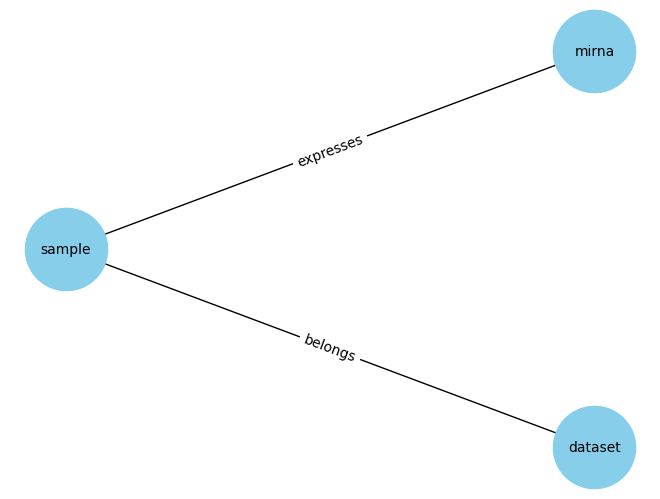


Node number
sample         : 25484
dataset        : 30
mirna          : 2588

Edge number
belongs        : 25484
expresses      : 60364435

Node features
sample         : 3
dataset        : 37
mirna          : 120

Edge features
belongs        : 0
expresses      : 1


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.data import HeteroData
from torch_geometric import transforms as T 


data = HeteroData()
metadata = pd.read_csv('data/PD.csv', index_col=0).sort_index().reset_index(drop=True)
mirna = pd.read_csv('data/EXP.csv', index_col=0).sort_index().reset_index(drop=True)

# Split samples into training and test set, stratifying by 'dataset' and 'disease' columns
metadata.disease.fillna('Healthy control', inplace=True)
train, test = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata[['dataset', 'disease']])

# Set features for 'sample' nodes
sex = torch.tensor(pd.get_dummies(metadata.sex).values, dtype=torch.float)
age = torch.tensor(metadata.age.values, dtype=torch.float).unsqueeze(-1)
data['sample'].x = torch.cat((sex, age), dim=-1)

# Set class labels for 'sample' nodes
data['sample'].y = torch.tensor(metadata.disease.factorize()[0])

# Set train and test masks for 'sample' nodes
data['sample'].train_mask = torch.zeros(data['sample'].num_nodes, dtype=torch.bool)
data['sample'].train_mask[train.index] = True
data['sample'].test_mask = torch.zeros(data['sample'].num_nodes, dtype=torch.bool)
data['sample'].test_mask[test.index] = True

# Set features for 'dataset' nodes
datasets = metadata.loc[:, metadata.columns.str.startswith('dataset')].groupby('dataset').first()
xs = [torch.tensor(pd.get_dummies(datasets[feature]).values, dtype=torch.float) for feature in datasets.columns]
data['dataset'].x = torch.cat(xs, dim=-1)

# Set features for 'mirna' nodes
embeddings = torch.load('data/miRNA_emb.pt')
data['mirna'].x = torch.tensor(np.array([embeddings[name] for name in mirna.columns]))

# Set 'belongs' edges between 'sample' and 'dataset' nodes
data['sample', 'belongs', 'dataset'].edge_index = torch.tensor(np.array([metadata.index.to_numpy(), metadata.dataset.factorize()[0]]))

# Set 'expresses' edges between 'sample' and 'mirna' nodes
rows, cols = np.where(~np.isnan(mirna))
data['sample', 'expresses', 'mirna'].edge_index = torch.tensor(np.array([rows, cols]))

# Set features for 'expresses' edges
data['expresses'].edge_attr = torch.tensor(mirna.values[rows, cols], dtype=torch.float)

# Visualize graph schema
schema = nx.Graph()
schema.add_nodes_from(data.node_types)
edges = {(e[0], e[2]): e[1] for e in data.edge_types}
schema.add_edges_from(edges.keys())
pos = nx.shell_layout(schema)
nx.draw(schema, pos, with_labels=True, node_color='skyblue', node_size=3500, font_size=10)
nx.draw_networkx_edge_labels(schema, pos, edge_labels=edges)
plt.show()

# Visualize graph properties
print(f'\033[1m\nNode number\033[0m')
for ntype in data.node_types:
   print(f'{ntype:<15}:', data[ntype].num_nodes)

print(f'\033[1m\nEdge number\033[0m')
for etype in data.edge_types:
   print(f'{etype[1]:<15}:', data[etype].num_edges)

print(f'\n\033[1mNode features\033[0m')
for ntype in data.node_types:
   print(f'{ntype:<15}:', data[ntype].num_node_features)

print(f'\033[1m\nEdge features\033[0m')
for etype in data.edge_types:
   print(f'{etype[1]:<15}:', data[etype].num_edge_features)

# Create undirected graph by adding reverse edges
data = T.ToUndirected()(data)

# Check that edge_index hold indices in the range [0, num_nodes-1]
data.validate(raise_on_error=True)

# Save graph
torch.save(data, 'data/graph.pt')

# Heterogeneous GNN

**Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations. This is done by following a **neighborhood aggregation** or **message passing scheme**. With $\mathbf{x}^{(k-1)}_i \in \mathbb{R}^F$ denoting node features of node $i$ in layer $(k-1)$ and $\mathbf{e}_{j,i} \in \mathbb{R}^D$ denoting (optional) edge features from node $j$ to node $i$, message passing graph neural networks can be described as:

$$
\mathbf{x}_i^{(k)} = \gamma^{(k)} \left( \mathbf{x}_i^{(k-1)}, \bigoplus_{j \in \mathcal{N}(i)} \, \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{j,i}\right) \right),
$$

where $\bigoplus$ denotes a differentiable, permutation invariant function, e.g., sum, mean or max, and $\gamma$ and $\phi$ denote differentiable functions such as MLPs (Multi Layer Perceptrons). Heterogeneous graphs come with different types of information attached to nodes and edges. As a consequence of the different data structure, the message passing formulation changes accordingly, allowing the computation of message and update function conditioned on node or edge type.

In [1]:
import pandas as pd
import torch
from torch_geometric import seed_everything, compile
from torch_geometric.nn import GAT, to_hetero
from torch_geometric.loader import NeighborLoader


seed_everything(42)
data = torch.load('data/graph.pt')


model = GAT(in_channels=-1, hidden_channels=64, out_channels=int(data['sample'].y.max()) + 1, num_layers=3, v2=True, add_self_loops=False)

# Convert homogenous GNN to heterogenous GNN
model = to_hetero(model, data.metadata(), aggr='sum')
compile(model)

with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict)